In [ ]:
import spatialdm as sdm
import pandas as pd
import numpy as np
import anndata as ann
from sklearn import metrics
from matplotlib import pyplot as plt
import scanpy as sc
from scipy import sparse

methods = ["truth", "Tangram", "transImpute", "transImpSpa", "transImpCls", "transImpClsSpa", "spaGE", "stPlus"]
name_mapping = {"transImpute":"TransImp", "transImpSpa":"TransImpSpa", "transImpCls":"TransImpCls", "transImpClsSpa":"TransImpClsSpa"}
tmp_loc_path = "../../output/locations/#.csv"
tmp_counts_path = "../../output/#ext_singlecell_$.csv"
ST_names = ["melanoma", "mouseliver", "intest", "breastcancer"]
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']

In [ ]:
def merge_data(imp_adata, adata):
    valid_genes = [g for g in adata.var_names if g not in imp_adata.var_names]
    print(f"Valid genes: {len(valid_genes)}, Ex genes: {imp_adata.shape[1]}")
    X = adata[:, valid_genes].X
    if sparse.issparse(X):
        X = X.toarray()
    X = np.hstack([X, imp_adata.X])
    m_adata = sc.AnnData(X, dtype=np.float32)
    m_adata.var_names = np.concatenate([valid_genes, imp_adata.var_names.values])
    return m_adata
    
    
def breastcancer_ST():
    spa_adata = sc.read_mtx("../../data/ST/BreastCancer/filtered_count_matrices/1142243F_filtered_count_matrix/matrix.mtx").T
    spa_adata.var_names = pd.read_csv("../../data/ST/BreastCancer/filtered_count_matrices/1142243F_filtered_count_matrix/features.tsv", header=None).iloc[:, 0].values
    return spa_adata

def mouseliver_ST():
    return sc.read_csv(f"../../data/ST/MouseLiver/SCP2046/expression/processed_c1.csv.gz").T.copy()

def melanoma_ST():
    spa_adata = sc.read_h5ad("../../data/ST/melanoma/spatial.h5ad")
    spa_adata = spa_adata[:, (spa_adata.var_names.values != 'MARCH1') & (spa_adata.var_names.values != 'MARCH2')].copy()
    return spa_adata

def intestine_ST():
    return sc.read_h5ad("../../data/ST/intest/A1.h5ad")

In [ ]:
def read_data(ST_name):
    mapping = {"melanoma":melanoma_ST, 
     "mouseliver":mouseliver_ST, 
     "intest":intestine_ST, 
     "breastcancer":breastcancer_ST}
    loc = pd.read_csv(tmp_loc_path.replace("#", ST_name))
    adatas = {}
    for method in methods:
        map_name = name_mapping[method] if method in name_mapping else method
        adatas[map_name] = merge_data(ann.read_csv(tmp_counts_path.replace("#", ST_name).replace("$", method)), mapping[ST_name]())
        adatas[map_name] = adatas[map_name][:, ~(adatas[map_name].var_names == "")]
        adatas[map_name].obsm['spatial'] = loc.values
        if "truth" in adatas:
            adatas[map_name] = adatas[map_name][:, adatas['truth'].var_names].copy()
    return adatas

def spatialdm(adata, spec, l):
    sdm.weight_matrix(adata, l=l, cutoff=0.2, single_cell=False)
    # find overlapping LRs from CellChatDB
    sdm.extract_lr(adata, spec, min_cell=0)
    # global Moran selection
    # print(adata.uns)
    # print(adata)
    cp_adata = None
    try:
        sdm.spatialdm_global(adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(adata, method='z-score', fdr=True, threshold=0.1)        
    except Exception as e:
        # print(e)
        cp_adata = adata.copy()
        sdm.extract_lr(cp_adata, spec, min_cell=1)
        sdm.spatialdm_global(cp_adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(cp_adata, method='z-score', fdr=True, threshold=0.1)
    # select significant pairs
    if not cp_adata is None:
        full_set = adata.uns['geneInter'].interaction_name
        # print(np.intersect1d(full_set, cp_adata.uns['global_res'].index.values))
        full_global_res = cp_adata.uns['global_res'].copy()
        full_global_res['global_I'] = cp_adata.uns['global_I'].copy()
        for pair in full_set:
            if pair not in cp_adata.uns['global_res'].index.values:
                # z	perm_pval	fdr	selected
                full_global_res = pd.concat([full_global_res, pd.DataFrame({
                    "Ligand0":{pair:pair.split("_")[0]},
                    "Receptor0":{pair:pair.split("_")[1]},
                    "Receptor1":{pair:None},
                    "z_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "z":{pair:np.random.rand()*0.01},
                    "perm_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "fdr":{pair:0.99 + np.random.rand() * 0.01},
                    "selected":{pair:False},
                    "global_I":{pair:np.random.rand() * 1e-6},
                })])
        # print(np.intersect1d(full_global_res.index, cp_adata.uns['global_res'].index.values))        
        adata.uns['global_res'] = full_global_res.loc[adata.uns['geneInter'].interaction_name].copy()
        adata.uns['global_I'] = full_global_res.global_I.values
        
        
    valid_genes = [True if l != r else False for l,r in zip(adata.uns['global_res'].Ligand0, adata.uns['global_res'].Receptor0)]
    print(len(valid_genes), adata.uns['global_res'].shape[0])
    sel = adata.uns['global_res'].index[valid_genes]
    adata.uns['global_res'] = adata.uns['global_res'].loc[sel]
    adata.uns['global_I'] = adata.uns['global_I'][valid_genes]
    adata.uns['global_res'].sort_values(by='fdr')
    print(adata.uns['global_res'].shape)
    
def precision_recall_curve(adatas, dataset_name):
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in adatas:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        
        prec, rec, thresholds  = metrics.precision_recall_curve(y, score, pos_label=1)
        
        disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.average_precision_score(y, score):.2f})", color=color[idx])
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Precison-Recall Curve on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()   
    
def roc_curve(adatas, dataset_name):     
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in adatas:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        fpr, tpr, thresholds  = metrics.roc_curve(y, score, pos_label=1)
        
        auc_score = metrics.auc(fpr, tpr)
        
        disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
        
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.roc_auc_score(y, score):.2f})", color=color[idx])
        
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Receiver Operating Characteristic on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()
    
adata_dict = {}    
for ST_name, spec, l in zip(ST_names, 
                         ["human", "mouse", "human", "human"],
                         [1.2, 75, 20, 20]
                         ):
    print(ST_name, spec, l)
    adatas = read_data(ST_name)
    for md in adatas:
        spatialdm(adatas[md], spec, l)
    adata_dict[f"{ST_name}_{spec}"] = adatas
    precision_recall_curve(adatas, ST_name)
    roc_curve(adatas, ST_name)
    print("#"*25)

    
    

In [ ]:
import pickle
with open("../../output/spatialdm.pkl", 'wb') as outfile:
    pickle.dump(adata_dict, outfile)

In [ ]:
import pickle
with open("../../output/spatialdm.pkl", 'rb') as infile:
    adata_dict = pickle.load( infile)

melanoma_human
# 566 pairs
# 566 pairs
# 566 pairs
# 566 pairs
# 566 pairs
# 566 pairs
# 566 pairs


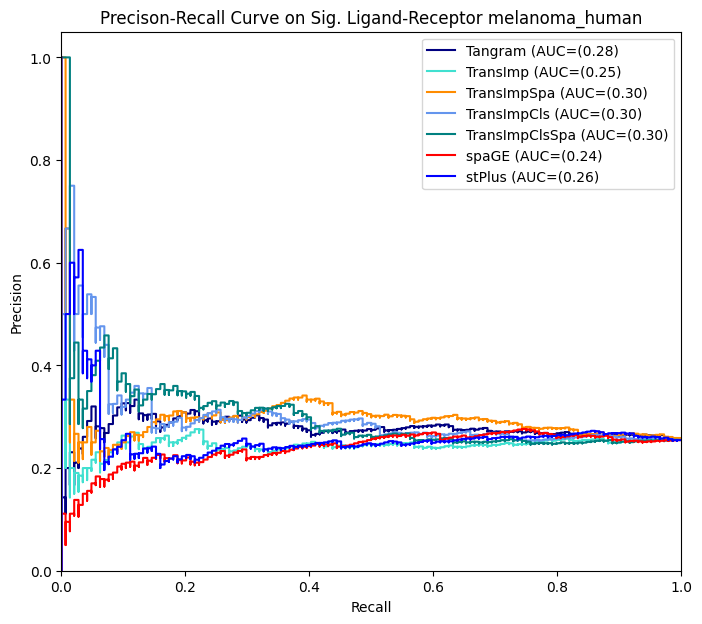

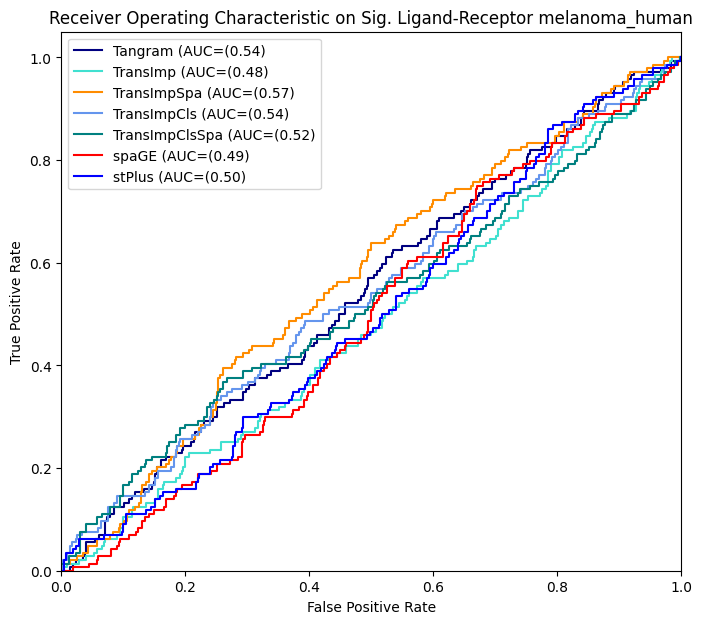

#########################
mouseliver_mouse
# 878 pairs
# 878 pairs
# 878 pairs
# 878 pairs
# 878 pairs
# 878 pairs
# 878 pairs


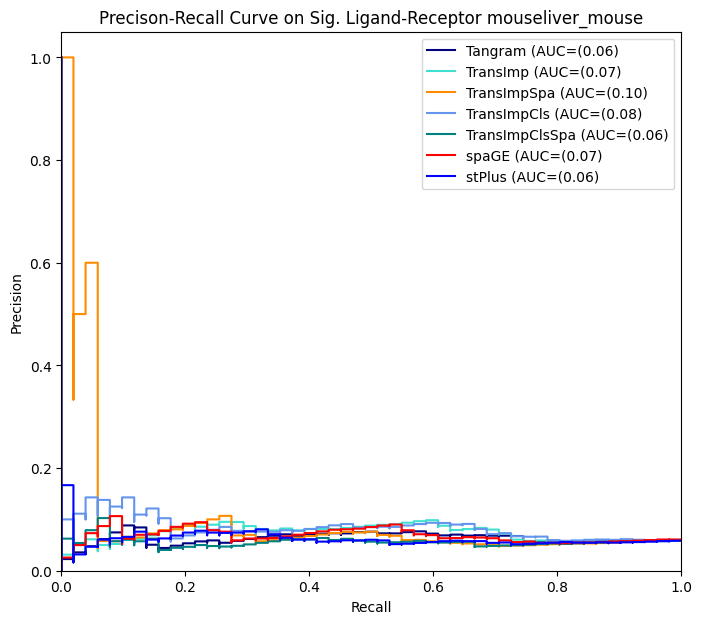

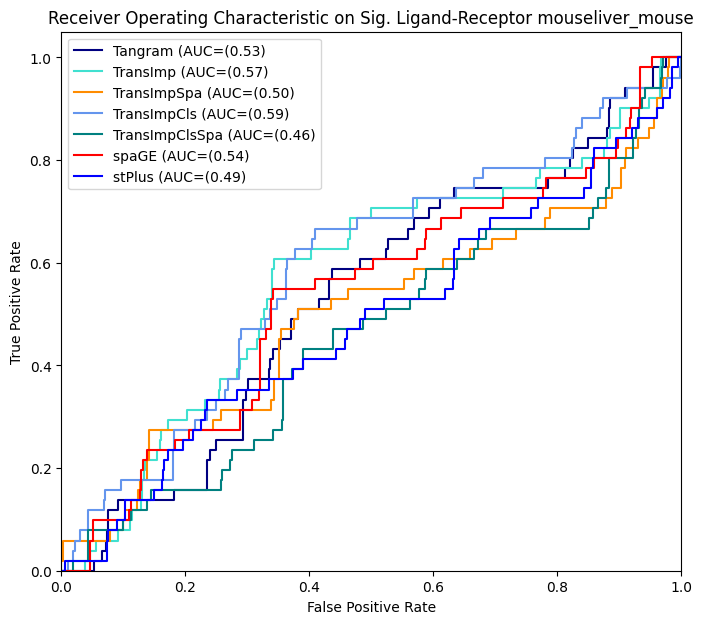

#########################
intest_human
# 1276 pairs
# 1276 pairs
# 1276 pairs
# 1276 pairs
# 1276 pairs
# 1276 pairs
# 1276 pairs


/tmp/ipykernel_55698/1073656575.py:18: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
/tmp/ipykernel_55698/1073656575.py:18: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
/tmp/ipykernel_55698/1073656575.py:18: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
/tmp/ipykernel_55698/1073656575.py:18: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)


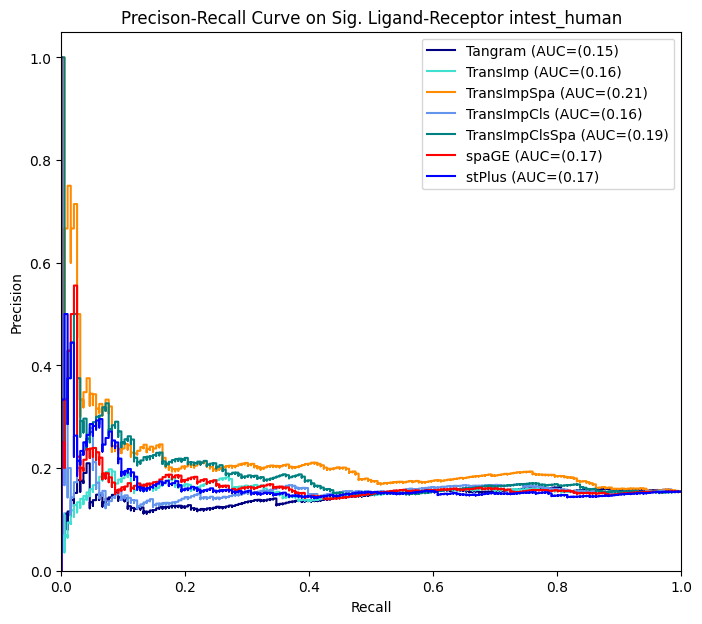

/tmp/ipykernel_55698/1073656575.py:56: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
/tmp/ipykernel_55698/1073656575.py:56: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
/tmp/ipykernel_55698/1073656575.py:56: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
/tmp/ipykernel_55698/1073656575.py:56: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)


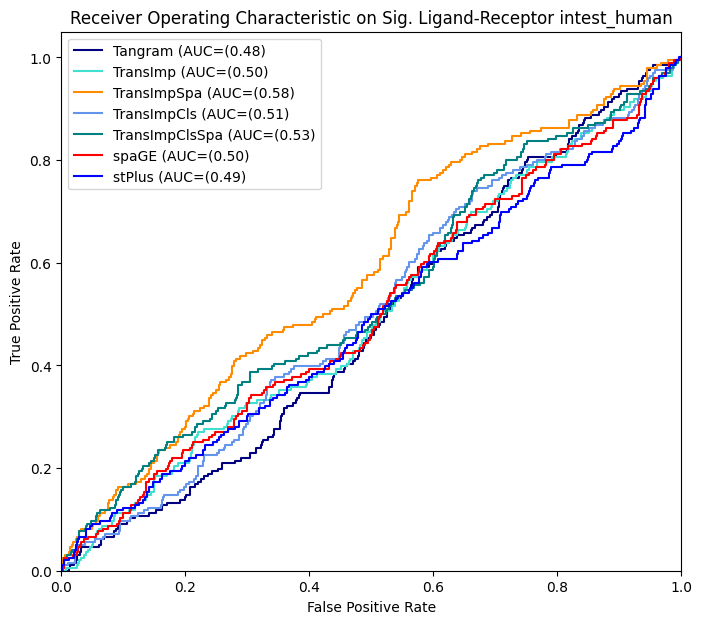

#########################
breastcancer_human
# 1165 pairs
# 1165 pairs
# 1165 pairs
# 1165 pairs
# 1165 pairs
# 1165 pairs
# 1165 pairs


/tmp/ipykernel_55698/1073656575.py:18: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
/tmp/ipykernel_55698/1073656575.py:18: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
/tmp/ipykernel_55698/1073656575.py:18: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
/tmp/ipykernel_55698/1073656575.py:18: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
/tmp/ipykernel_55698/1073656575.py:18: RuntimeWarning: divide by zero encountered in log
  s

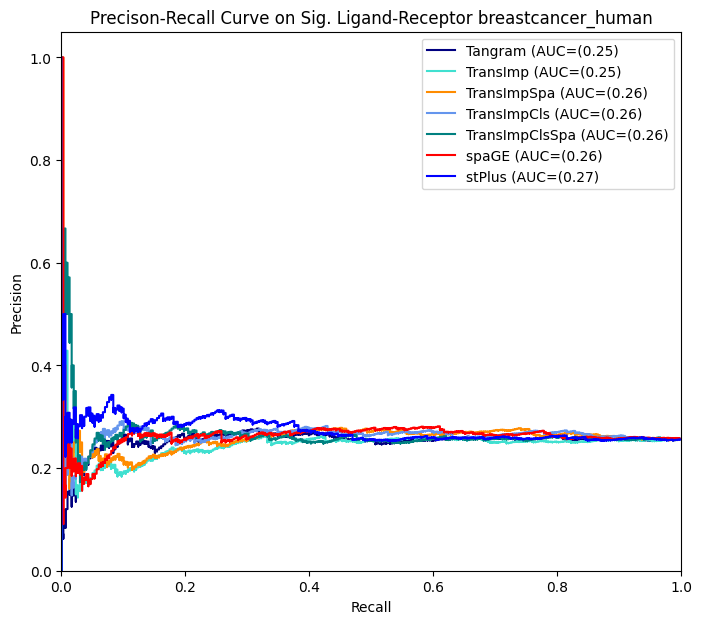

/tmp/ipykernel_55698/1073656575.py:56: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
/tmp/ipykernel_55698/1073656575.py:56: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
/tmp/ipykernel_55698/1073656575.py:56: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
/tmp/ipykernel_55698/1073656575.py:56: RuntimeWarning: divide by zero encountered in log
  score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
/tmp/ipykernel_55698/1073656575.py:56: RuntimeWarning: divide by zero encountered in log
  s

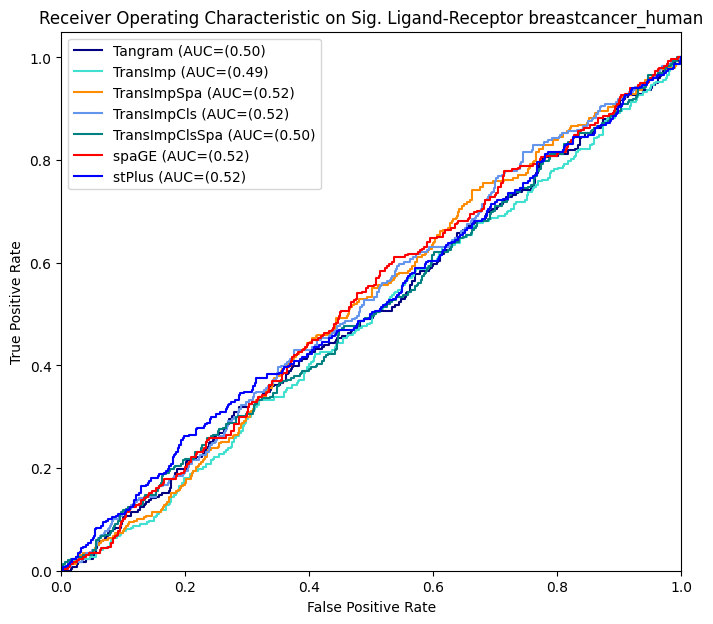

#########################


In [7]:
from scipy.special import expit
def precision_recall_curve(adatas, dataset_name):
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in adatas:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        print(f"# {len(genes)} pairs")
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(adatas[md].uns['global_res'].loc[genes].fdr.values)
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        new_scores = list(range(len(score)))
        score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # plt.hist(score, bins=100);plt.show()
        # score = expit(score)
        # plt.hist(score, bins=100)
        # plt.show()
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        
        prec, rec, thresholds  = metrics.precision_recall_curve(y, score, pos_label=1)
        
        disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.average_precision_score(y, score):.2f})", color=color[idx])
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Precison-Recall Curve on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()   
    
def roc_curve(adatas, dataset_name):     
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in adatas:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000)
       
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        new_scores = list(range(len(score)))
        score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # score = expit(score)
        fpr, tpr, thresholds  = metrics.roc_curve(y, score, pos_label=1)
        
        auc_score = metrics.auc(fpr, tpr)
        
        disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
        
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.roc_auc_score(y, score):.2f})", color=color[idx])
        
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Receiver Operating Characteristic on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()
    
  
for ST_name, adatas in adata_dict.items():
    print(ST_name)
    precision_recall_curve(adatas, ST_name)
    roc_curve(adatas, ST_name)
    print("#"*25)